In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import os
import gc

In [2]:
# 测试集所有用户都在训练集中
# 测试集中有50w商品记录，8w商品，120个品牌不在训练集中
train = pd.read_csv('../data/user_action_train.txt', sep='\t', names=['uid','spu_id','action_type','date'], 
                    dtype={'uid':np.int32, 'spu_id': np.int32, 'action_type': np.int8, 'date': str})
goods = pd.read_csv('../data/goods_train.txt', sep='\t', names=['spu_id','brand_id','cat_id'], 
                    dtype={'spu_id':np.int32, 'brand_id': np.int32, 'cat_id': np.int32})
#test = pd.read_csv('../data/user_action_test_items.txt', sep='\t', names=['uid','spu_id'], usecols=['uid','spu_id'],
#                    dtype={'uid':np.int32, 'spu_id': np.int32})

In [3]:
date_map = {'01': 0, '02': 31, '03': 31+26}
f = lambda d: date_map[d[0]]+int(d[1])
train.loc[:,'date'] = [f(d.split('-')) for d in train.date]
train.date = train.date.astype(np.int16)
train = pd.merge(train, goods, how='left', on='spu_id')
#test = pd.merge(test, goods, how='left', on='spu_id')
del goods

In [16]:
train_82 = train[train.date>=82]
uis = train_82.groupby(['cat_id','brand_id']).size().reset_index()
uis = uis.groupby('cat_id').size().reset_index()
uis.columns = ['cat_id','user_item_act_num']
train_82 = pd.merge(train_82, uis, how='left', on=['cat_id'])

In [9]:
test.rename(index=str, columns={"uid": "user_id"})

,user_id,spu_id,brand_id,cat_id
0,117570,771214,10000223,1056
1,60750,1580520,10012892,28008
2,595361,484220,10005367,311
3,45427,326736,10004119,28006
4,443345,1049603,10012721,680
5,318510,74820,10004119,28006
6,462921,1884230,10010209,311
7,150120,1448713,10004760,337
8,6049,1326894,10015703,311
9,627869,1964082,10003640,271


In [17]:
ss = train.groupby(['uid','spu_id']).size().reset_index()
ss = pd.merge(train, ss, how='how', on=['uid','spu_id']).groupby(['uid','spu_id'])

In [28]:
train[train.date>=82][~train[train.date>=82].cat_id.isin(train[train.date<82].cat_id)].groupby(['action_type']).size()

action_type
0    1
dtype: int64

In [6]:
ui = train[train.action_type==1].groupby(['uid','spu_id']).size().reset_index()
ui.columns = ['uid','spu_id','buy_num']
u_75 = train[train.date<75].groupby('uid').size().reset_index()
u_82 = train[train.date<82].groupby('uid').apply(lambda g: len(g[g.action_type==1])).reset_index()
u_75.columns = ['uid','user_act_sum_75']    # 75日前用户的行为总数
u_82.columns = ['uid','user_buy_sum_82']    # 82日前用户的购买总数
i_75 = train[train.date<75].groupby('spu_id').size().reset_index()
i_82 = train[train.date<82].groupby('spu_id').apply(lambda g: len(g[g.action_type==1])).reset_index()
i_75.columns = ['spu_id','item_act_sum_75'] # 75日前商品的行为总数
i_82.columns = ['spu_id','item_buy_sum_82'] # 82日前商品的购买总数

In [7]:
t = pd.merge(train, ui, how='left', on=['uid','spu_id'])
t = pd.merge(t, u_75, how='left', on=['uid'])
t = pd.merge(t, u_82, how='left', on=['uid'])
t = pd.merge(t, i_75, how='left', on=['spu_id'])
t = pd.merge(t, i_82, how='left', on=['spu_id'])
t.fillna(0, inplace=True)
t.loc[:,'user_buy82_act75_ratio'] = t.user_buy_sum_82/t.user_act_sum_75
t.loc[:,'item_buy82_act75_ratio'] = t.item_buy_sum_82/t.item_act_sum_75
t = t.sort_values(['uid','date']).reset_index()
del t['index']

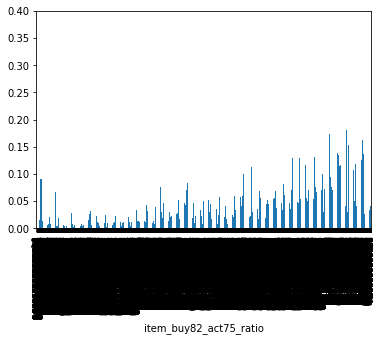

In [55]:
plt.xlim(0, .9)
plt.ylim(0, .4)
#ax = plt.gca()
# ax = plt.figure(figsize=(7,5), dpi=100).add_subplot(111)
t[t.date>=82].groupby(['item_buy82_act75_ratio']).apply(lambda g: (len(g[g.action_type==1])+1)/float(len(g)+10)).plot(kind='bar')
#ax.set_xticks([])
'''
ax.set_xticks([], minor=True)
ax.xaxis.grid(True, which="minor")
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.plot(np.arange(11), np.zeros(11))
'''
plt.xticks(rotation='vertical', fontsize = 8)
#plt.subplots_adjust(bottom=.1)
plt.show()

In [9]:
#s1 = t[t.date<30].groupby(['cat_id','brand_id']).size().reset_index()
#s1.columns = ['cat_id','brand_id','size']
#s2 = t[(t.date>=30)&(t.date<60)].groupby(['cat_id','brand_id']).size().reset_index()
#s2.columns = ['cat_id','brand_id','size']
#s3 = t[(t.date>=60)&(t.date<90)].groupby(['cat_id','brand_id']).size().reset_index()
#s3.columns = ['cat_id','brand_id','size']
#print s1.sort_values(['cat_id','size'],ascending=False).head(12)
#print s2.sort_values(['cat_id','size'],ascending=False).head(12)
#print s3.sort_values(['cat_id','size'],ascending=False).head(12)
s1 = t[t.date<32].groupby(['cat_id']).apply(lambda g: len(g[g.action_type==1]+100)/float(len(g)+1000)).reset_index()
s2 = t[(t.date>=32)&(t.date<58)].groupby(['cat_id']).apply(lambda g: len(g[g.action_type==1]+100)/float(len(g)+1000)).reset_index()
s3 = t[(t.date>=58)&(t.date<88)].groupby(['cat_id']).apply(lambda g: len(g[g.action_type==1]+100)/float(len(g)+1000)).reset_index()
s1.columns = ['cat_id','view_1']
s2.columns = ['cat_id','view_2']
s3.columns = ['cat_id','view_3']
s1 = pd.merge(s1, s2, how='left', on='cat_id')
s1 = pd.merge(s1, s3, how='left', on='cat_id')
s1.loc[:, 'change'] = s1['view_3'] -s1['view_1']
print s1.sort_values(['change'],ascending=False)

    cat_id    view_1    view_2    view_3    change
18   26965  0.074892  0.069463  0.088415  0.013523
29   28005  0.025999  0.039538  0.036538  0.010539
47   75799  0.000755  0.002095  0.007576  0.006821
11     945  0.038221  0.052210  0.043348  0.005127
27   27971  0.001889  0.001896  0.007005  0.005117
30   28006  0.013109  0.015645  0.017337  0.004228
33   28009  0.039644  0.044558  0.042686  0.003042
31   28007  0.016805  0.020571  0.019808  0.003003
15    6507  0.001921  0.000000  0.004730  0.002809
46   75798  0.000000  0.000000  0.002597  0.002597
20   26971  0.018824  0.014202  0.021193  0.002369
3      337  0.011778  0.013133  0.014131  0.002353
10     688  0.027150  0.028362  0.029495  0.002345
40   50513  0.000000  0.000000  0.001969  0.001969
13    1056  0.005979  0.007087  0.007794  0.001815
23   26980  0.027875  0.025988  0.028993  0.001118
35   42067  0.010157  0.009714  0.011261  0.001104
28   28004  0.022745  0.022092  0.023785  0.001040
2      311  0.004047  0.004624 

In [80]:
#t = pd.merge(t, s1[['cat_id','change']], how='left', on='cat_id')
t[t.date>60].groupby(['change_y','action_type']).size().reset_index().head(60)

,change_y,action_type,0
0,0.098039,0,344
1,0.116505,0,133
2,0.116505,1,2
3,0.120000,0,15
4,0.120000,1,2
5,0.123894,0,62
6,0.123894,1,4
7,0.130000,0,624
8,0.130000,1,3
9,0.135922,0,205


In [4]:
def gen_user_feature(df_data, start_day, end_day):
    '''
    在特征提取区间内用户的行为特征: 总点击、购买、未购买点击 的 记录数、商品数、天数、购买率
    '''
    start_time = time.time()
    dump_path = '../cache/user_feature_%d_to_%d.csv'%(start_day, end_day)
    if os.path.exists(dump_path):
        actions = pd.read_csv(dump_path)
    else:
        df_data = df_data[(df_data.date >= start_day)&(df_data.date < end_day)]
        span = end_day - start_day
        
        # 用户行为总记录数
        actions = df_data.groupby('uid').size().reset_index()
        buy_sum = df_data[df_data.action_type == 1].groupby('uid').size().reset_index()
        actions.columns = ['uid', 'user_actions_sum_last_%d_days'%(span)]
        buy_sum.columns = ['uid', 'user_buy_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, buy_sum, how='left', on='uid')
        
        # 用户行为总商品数
        actions_spu = df_data.groupby(['uid','spu_id']).size().reset_index()
        actions_spu = actions_spu.groupby('uid').size().reset_index()
        actions_spu.columns = ['uid', 'user_item_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, actions_spu, how='left', on='uid')
        buy_sum = df_data[df_data.action_type == 1].groupby(['uid','spu_id']).size().reset_index()
        buy_sum = buy_sum.groupby('uid').size().reset_index()
        buy_sum.columns = ['uid', 'user_buy_item_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, buy_sum, how='left', on='uid')
        
        # 用户行为总品牌数
        actions_spu = df_data.groupby(['uid','brand_id']).size().reset_index()
        actions_spu = actions_spu.groupby('uid').size().reset_index()
        actions_spu.columns = ['uid', 'user_brand_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, actions_spu, how='left', on='uid')
        buy_sum = df_data[df_data.action_type == 1].groupby(['uid','brand_id']).size().reset_index()
        buy_sum = buy_sum.groupby('uid').size().reset_index()
        buy_sum.columns = ['uid', 'user_buy_brand_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, buy_sum, how='left', on='uid')
        
        # 用户行为总类别数
        actions_spu = df_data.groupby(['uid','cat_id']).size().reset_index()
        actions_spu = actions_spu.groupby('uid').size().reset_index()
        actions_spu.columns = ['uid', 'user_cat_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, actions_spu, how='left', on='uid')
        buy_sum = df_data[df_data.action_type == 1].groupby(['uid','cat_id']).size().reset_index()
        buy_sum = buy_sum.groupby('uid').size().reset_index()
        buy_sum.columns = ['uid', 'user_buy_cat_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, buy_sum, how='left', on='uid')
        
        # 用户行为总天数
        actions_days = df_data.groupby(['uid','date']).size().reset_index()
        actions_days = actions_days.groupby('uid').size().reset_index()
        actions_days.columns = ['uid', 'user_days_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, actions_days, how='left', on='uid')
        buy_sum = df_data[df_data.action_type == 1].groupby(['uid','date']).size().reset_index()
        buy_sum = buy_sum.groupby('uid').size().reset_index()
        buy_sum.columns = ['uid', 'user_buy_days_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, buy_sum, how='left', on='uid')
        
        # 用户购买比率
        actions.loc[:,'user_buy_sum_ratio_last_%d_days'%(span)] = \
                    (actions['user_buy_sum_last_%d_days'%(span)]+1) / \
                    (actions['user_actions_sum_last_%d_days'%(span)]+10.)
        actions.loc[:,'user_buy_item_sum_ratio_last_%d_days'%(span)] = \
                    (actions['user_buy_item_sum_last_%d_days'%(span)]+1) / \
                    (actions['user_item_sum_last_%d_days'%(span)]+10.)
        actions.loc[:,'user_buy_brand_sum_ratio_last_%d_days'%(span)] = \
                    (actions['user_buy_brand_sum_last_%d_days'%(span)]+1) / \
                    (actions['user_brand_sum_last_%d_days'%(span)]+10.)
        actions.loc[:,'user_buy_cat_sum_ratio_last_%d_days'%(span)] = \
                    (actions['user_buy_cat_sum_last_%d_days'%(span)]+1) / \
                    (actions['user_cat_sum_last_%d_days'%(span)]+10.)
        actions.loc[:,'user_buy_days_sum_ratio_last_%d_days'%(span)] = \
                    (actions['user_buy_days_sum_last_%d_days'%(span)]+1) / \
                    (actions['user_days_sum_last_%d_days'%(span)]+10.)
        
        # 填充空值
        actions.fillna(0, inplace=True)
        
        # 缓存中间结果
        actions.to_csv(dump_path, index=False, float_format='%.4f')
        
    compress_data(actions)
    print 'generate user feature cost: %.4f s'%(time.time()-start_time)
    return actions

def gen_item_feature(df_data, start_day, end_day):
    '''
    在特征提取区间内商品的行为特征: 总点击、购买、未购买点击 的 记录数、用户数、天数
    '''
    start_time = time.time()
    dump_path = '../cache/item_feature_%d_to_%d.csv'%(start_day, end_day)
    if os.path.exists(dump_path):
        actions = pd.read_csv(dump_path)
    else:
        df_data = df_data[(df_data.date >= start_day)&(df_data.date < end_day)]
        span = end_day - start_day
        
        # 商品用户行为总记录数
        actions = df_data.groupby('spu_id').size().reset_index()
        buy_sum = df_data[df_data.action_type == 1].groupby('spu_id').size().reset_index()
        actions.columns = ['spu_id', 'item_actions_sum_last_%d_days'%(span)]
        buy_sum.columns = ['spu_id', 'item_buy_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, buy_sum, how='left', on='spu_id')
        
        # 商品行为总用户数
        actions_spu = df_data.groupby(['spu_id','uid']).size().reset_index()
        actions_spu = actions_spu.groupby('spu_id').size().reset_index()
        actions_spu.columns = ['spu_id', 'item_user_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, actions_spu, how='left', on='spu_id')
        buy_sum = df_data[df_data.action_type == 1].groupby(['spu_id','uid']).size().reset_index()
        buy_sum = buy_sum.groupby('spu_id').size().reset_index()
        buy_sum.columns = ['spu_id', 'item_buy_user_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, buy_sum, how='left', on='spu_id')
        
        # 商品行为总天数
        actions_days = df_data.groupby(['spu_id','date']).size().reset_index()
        actions_days = actions_days.groupby('spu_id').size().reset_index()
        actions_days.columns = ['spu_id', 'item_days_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, actions_days, how='left', on='spu_id')
        buy_sum = df_data[df_data.action_type == 1].groupby(['spu_id','date']).size().reset_index()
        buy_sum = buy_sum.groupby('spu_id').size().reset_index()
        buy_sum.columns = ['spu_id', 'item_buy_days_sum_last_%d_days'%(span)]
        actions = pd.merge(actions, buy_sum, how='left', on='spu_id')
        
        # 商品购买比率
        actions.loc[:,'item_buy_sum_ratio_last_%d_days'%(span)] = \
                    (actions['item_buy_sum_last_%d_days'%(span)]+1) / \
                    (actions['item_actions_sum_last_%d_days'%(span)]+10.)
        actions.loc[:,'item_buy_user_sum_ratio_last_%d_days'%(span)] = \
                    (actions['item_buy_user_sum_last_%d_days'%(span)]+1) / \
                    (actions['item_user_sum_last_%d_days'%(span)]+10.)
        actions.loc[:,'item_buy_days_sum_ratio_last_%d_days'%(span)] = \
                    (actions['item_buy_days_sum_last_%d_days'%(span)]+1) / \
                    (actions['item_days_sum_last_%d_days'%(span)]+10.)
                
        # 商品在品牌中的购买情况，是否是最大的总用户数、总浏览次数
        item_in_brand = df_data.groupby([''])        
        
        # 填充空值
        actions.fillna(0, inplace=True)
                            
        # 缓存中间结果
        actions.to_csv(dump_path, index=False, float_format='%.4f')
        
    compress_data(actions)
    print 'generate item feature cost: %.4f s'%(time.time()-start_time)
    return actions
                                
def gen_cross_feature(df_data, start_day, end_day):
    '''
    在特征提取区间内的交叉特征： 用户-商品、用户-品牌、用户-类别 的 交互次数、购买次数、访问比率、是否最大比率
    '''
    start_time = time.time()
    dump_path = '../cache/cross_feature_%d_to_%d.csv'%(start_day, end_day)
    if os.path.exists(dump_path):
        actions = pd.read_csv(dump_path)
    else:
        span = end_day - start_day
        df_data = df_data[(df_data.date >= start_day)&(df_data.date < end_day)]
        
        # 用户-商品特征 
        actions = df_data.groupby(['uid','spu_id']).size().reset_index()
        buy_sum = df_data[df_data.action_type == 1].groupby(['uid','spu_id']).size().reset_index()
    
        actions.columns = ['uid','spu_id','cross_actions_sum_last_%d_days'%(span)]
        buy_sum.columns = ['uid','spu_id','cross_buy_sum_last_%d_days'%(span)]
        
        actions = pd.merge(actions, buy_sum, how='left', on=['uid','spu_id'])

        actions.loc[:,'cross_buy_sum_ratio_last_%d_days'%(span)] = \
                    (actions['cross_buy_sum_last_%d_days'%(span)]+1) / \
                    (actions['cross_actions_sum_last_%d_days'%(span)]+10.)
                
        # 是否为用户的最大比率
        cross_max_rate = actions.groupby('uid').apply(lambda g: max(g['cross_buy_sum_ratio_last_%d_days'%(span)])).reset_index()
        cross_max_rate.columns = ['uid','cross_max_rate']
        actions = pd.merge(actions, cross_max_rate, how='left', on='uid')
        actions.loc[:,'cross_is_max_rate_last_%d_days'%(span)] = 0
        actions.loc[actions['cross_max_rate']==actions['cross_buy_sum_ratio_last_%d_days'%(span)],\
                    'cross_is_max_rate_last_%d_days'%(span)] = 1
        del actions['cross_max_rate']
    
        # 填充空值
        actions.fillna(0, inplace=True)
                            
        # 缓存中间结果
        actions.to_csv(dump_path, index=False, float_format='%.4f')
        
    compress_data(actions)
    print 'generate cross feature cost: %.4f s'%(time.time()-start_time)
    return actions
        
def gen_other_feature(df_data, start_day, end_day):
    '''
    其他特征
    '''
    start_time = time.time()
    dump_path = '../cache/other_feature_%d_to_%d.csv'%(start_day, end_day)
    if os.path.exists(dump_path):
        actions = pd.read_csv(dump_path)
    else:
        span = end_day - start_day
        df_data = df_data[(df_data.date >= start_day)&(df_data.date < end_day)]
        
        actions = df_data[df_data.action_type==1].groupby(['cat_id','brand_id','spu_id']).size().reset_index()
        actions.columns = ['cat_id','brand_id','spu_id','size']
        actions = actions[['cat_id','brand_id','spu_id']]
        
        # 是否是同品牌商品中最多购买的商品
        item_in_brand = df_data[df_data.action_type==1].groupby(['brand_id','spu_id']).size().reset_index()
        item_in_brand.columns = ['brand_id','spu_id','item_in_brand_buy_num_last_%d_days'%span]
        max_item_in_brand = item_in_brand.groupby('brand_id')['item_in_brand_buy_num_last_%d_days'%span].max().reset_index()
        max_item_in_brand.columns = ['brand_id','max_item_in_brand_last_%d_days'%span]
        
        actions = pd.merge(actions, item_in_brand, how='left', on=['spu_id','brand_id'])
        actions = pd.merge(actions, max_item_in_brand, how='left', on='brand_id')
        
        actions.loc[:,'is_max_item_in_brand_last_%d_days'%span] = 0
        actions.loc[actions['max_item_in_brand_last_%d_days'%span]==actions['item_in_brand_buy_num_last_%d_days'%span],\
                    'is_max_item_in_brand_last_%d_days'%span] = 1
        del actions['max_item_in_brand_last_%d_days'%span], max_item_in_brand, item_in_brand
        
        # 是否是同类别中最多购买的品牌
        brand_in_cat = df_data[df_data.action_type==1].groupby(['cat_id','brand_id']).size().reset_index()
        brand_in_cat.columns = ['cat_id','brand_id','brand_in_cat_buy_num_last_%d_days'%span]
        max_brand_in_cat = brand_in_cat.groupby('cat_id')['brand_in_cat_buy_num_last_%d_days'%span].max().reset_index()
        max_brand_in_cat.columns = ['cat_id','max_brand_in_cat_last_%d_days'%span]
        
        actions = pd.merge(actions, brand_in_cat, how='left', on=['brand_id','cat_id'])
        actions = pd.merge(actions, max_brand_in_cat, how='left', on='cat_id')
        
        actions.loc[:,'is_max_brand_in_cat_last_%d_days'%span] = 0
        actions.loc[actions['max_brand_in_cat_last_%d_days'%span]==actions['brand_in_cat_buy_num_last_%d_days'%span],\
                    'is_max_brand_in_cat_last_%d_days'%span] = 1
        del actions['max_brand_in_cat_last_%d_days'%span], brand_in_cat, max_brand_in_cat
        
        # 是否是同类别中最多购买的商品
        item_in_cat = df_data[df_data.action_type==1].groupby(['cat_id','spu_id']).size().reset_index()
        item_in_cat.columns = ['cat_id','spu_id','item_in_cat_buy_num_last_%d_days'%span]
        max_item_in_cat = item_in_cat.groupby('cat_id')['item_in_cat_buy_num_last_%d_days'%span].max().reset_index()
        max_item_in_cat.columns = ['cat_id','max_item_in_cat_last_%d_days'%span]
        
        actions = pd.merge(actions, item_in_cat, how='left', on=['spu_id','cat_id'])
        actions = pd.merge(actions, max_item_in_cat, how='left', on='cat_id')
        
        actions.loc[:,'is_max_item_in_cat_last_%d_days'%span] = 0
        actions.loc[actions['max_item_in_cat_last_%d_days'%span]==actions['item_in_cat_buy_num_last_%d_days'%span],\
                    'is_max_item_in_cat_last_%d_days'%span] = 1
        del actions['max_item_in_cat_last_%d_days'%span], item_in_cat, max_item_in_cat
        
        # 缓存中间结果
        cols = [
            'spu_id',
            'item_in_brand_buy_num_last_%d_days'%span,
            'brand_in_cat_buy_num_last_%d_days'%span,
            'item_in_cat_buy_num_last_%d_days'%span,
            'is_max_item_in_brand_last_%d_days'%span,
            'is_max_brand_in_cat_last_%d_days'%span,
            'is_max_item_in_cat_last_%d_days'%span
        ]
        actions = actions[cols]
        actions.to_csv(dump_path, index=False, float_format='%.4f')
        
    compress_data(actions)
    print 'generate other feature cost: %.4f s'%(time.time()-start_time)
    return actions

def max_feature(df_data, group_name, feat_name):
    max_f = df_data.groupby(group_name)[feat_name].max().reset_index()
    max_f.rename(columns={feat_name:'max_'+feat_name}, inplace=True)
    return pd.merge(df_data, max_f, how='left', on=group_name)

def min_feature(df_data, group_name, feat_name):
    min_f = df_data.groupby(group_name)[feat_name].min().reset_index()
    min_f.rename(columns={feat_name:'min_'+feat_name}, inplace=True)
    return pd.merge(df_data, min_f, how='left', on=group_name)

def avg_feature(df_data, group_name, feat_name):
    avg_f = df_data.groupby(group_name)[feat_name].mean().reset_index()
    avg_f.rename(columns={feat_name:'avg_'+feat_name}, inplace=True)
    return pd.merge(df_data, avg_f, how='left', on=group_name)

def gen_leak_feature(df_data, start_day, end_day):
    ''' 使用测试区间数据构造的特征: 用户访问商品、品牌和类别的次数，最多访问次数标记，品牌和类别中最多访问的商品标记 '''
    start_time = time.time()
    dump_path = '../cache/leak_feature_%d_to_%d.csv'%(start_day, end_day)
    if os.path.exists(dump_path):
        actions = pd.read_csv(dump_path)
    else:
        actions = df_data.groupby(['uid','spu_id','brand_id','cat_id']).size().reset_index()
        actions = actions[['uid','spu_id','brand_id','cat_id']]
        
        # 用户访问的唯一商品次数，测试集特点不重复计算
        uis = df_data.groupby(['uid','spu_id']).size().reset_index()
        uis = uis.groupby('uid').size().reset_index()
        uis.columns = ['uid','user_item_num']
        actions = pd.merge(actions, uis, how='left', on=['uid'])
        
        # 用户访问的唯一品牌数
        ubs = df_data.groupby(['uid','brand_id']).size().reset_index()
        ubs = ubs.groupby('uid').size().reset_index()
        ubs.columns = ['uid','user_brand_num']
        actions = pd.merge(actions, ubs, how='left', on=['uid'])
        
        # 用户访问的唯一类别数
        ucs = df_data.groupby(['uid','cat_id']).size().reset_index()
        ucs = ucs.groupby('uid').size().reset_index()
        ucs.columns = ['uid','user_cat_num']
        actions = pd.merge(actions, ucs, how='left', on=['uid'])
        
        # 商品记录中的唯一用户数
        ius = df_data.groupby(['spu_id','uid']).size().reset_index()
        ius = ius.groupby('spu_id').size().reset_index()
        ius.columns = ['spu_id','item_user_num']
        actions = pd.merge(actions, ius, how='left', on=['spu_id'])
        
        # 品牌记录中的唯一用户数
        bus = df_data.groupby(['brand_id','uid']).size().reset_index()
        bus = bus.groupby('brand_id').size().reset_index()
        bus.columns = ['brand_id','brand_user_num']
        actions = pd.merge(actions, bus, how='left', on=['brand_id'])
        
        del bus, ius, ucs, ubs, uis
        
        # 用户访问品牌中的唯一商品数
        ubs = df_data.groupby(['uid','brand_id','spu_id']).size().reset_index()
        ubs = ubs.groupby(['uid','brand_id']).size().reset_index()
        ubs.columns = ['uid','brand_id','user_brand_item_num']
        ubs = max_feature(ubs, ['uid'], 'user_brand_item_num')
        ubs = min_feature(ubs, ['uid'], 'user_brand_item_num')
        ubs = avg_feature(ubs, ['uid'], 'user_brand_item_num')
        ubs.loc[:, 'diff_max_user_brand_item_num'] = ubs.max_user_brand_item_num - ubs.user_brand_item_num
        ubs.loc[:, 'diff_avg_user_brand_item_num'] = abs(ubs.avg_user_brand_item_num - ubs.user_brand_item_num)
        ubs.loc[:, 'is_max_user_brand_item_num'] = 0
        ubs.loc[:, 'is_min_user_brand_item_num'] = 0
        ubs.loc[ubs.max_user_brand_item_num==ubs.user_brand_item_num, 'is_max_user_brand_item_num'] = 1
        ubs.loc[ubs.min_user_brand_item_num==ubs.user_brand_item_num, 'is_min_user_brand_item_num'] = 1
        del ubs['max_user_brand_item_num'], ubs['min_user_brand_item_num']
        actions = pd.merge(actions, ubs, how='left', on=['uid','brand_id'])
        
        # 用户访问类别中的唯一品牌数        
        ucb = df_data.groupby(['uid','cat_id','brand_id']).size().reset_index()
        ucb = ucb.groupby(['uid','cat_id']).size().reset_index()
        ucb.columns = ['uid','cat_id','user_cat_brand_num']
        ucb = max_feature(ucb, ['uid'], 'user_cat_brand_num')
        ucb = min_feature(ucb, ['uid'], 'user_cat_brand_num')
        ucb = avg_feature(ucb, ['uid'], 'user_cat_brand_num')
        ucb.loc[:, 'diff_max_user_cat_brand_num'] = ucb.max_user_cat_brand_num - ucb.user_cat_brand_num
        ucb.loc[:, 'diff_avg_user_cat_brand_num'] = abs(ucb.avg_user_cat_brand_num - ucb.user_cat_brand_num)
        ucb.loc[:, 'is_max_user_cat_brand_num'] = 0
        ucb.loc[:, 'is_min_user_cat_brand_num'] = 0
        ucb.loc[ucb.max_user_cat_brand_num==ucb.user_cat_brand_num, 'is_max_user_cat_brand_num'] = 1
        ucb.loc[ucb.min_user_cat_brand_num==ucb.user_cat_brand_num, 'is_min_user_cat_brand_num'] = 1
        del ucb['max_user_cat_brand_num'], ucb['min_user_cat_brand_num']
        actions = pd.merge(actions, ucb, how='left', on=['uid','cat_id'])
        
        # 用户访问类别中的唯一商品次数
        ucs = df_data.groupby(['uid','cat_id','spu_id']).size().reset_index()
        ucs = ucs.groupby(['uid','cat_id']).size().reset_index()
        ucs.columns = ['uid','cat_id','user_cat_item_num']
        ucs = max_feature(ucs, ['uid'], 'user_cat_item_num')
        ucs = min_feature(ucs, ['uid'], 'user_cat_item_num')
        ucs = avg_feature(ucs, ['uid'], 'user_cat_item_num')
        ucs.loc[:, 'diff_max_user_cat_item_num'] = ucs.max_user_cat_item_num - ucs.user_cat_item_num
        ucs.loc[:, 'diff_avg_user_cat_item_num'] = abs(ucs.avg_user_cat_item_num - ucs.user_cat_item_num)
        ucs.loc[:, 'is_max_user_cat_item_num'] = 0
        ucs.loc[:, 'is_min_user_cat_item_num'] = 0
        ucs.loc[ucs.max_user_cat_item_num==ucs.user_cat_item_num, 'is_max_user_cat_item_num'] = 1
        ucs.loc[ucs.min_user_cat_item_num==ucs.user_cat_item_num, 'is_min_user_cat_item_num'] = 1
        del ucs['max_user_cat_item_num'], ucs['min_user_cat_item_num']
        actions = pd.merge(actions, ucs, how='left', on=['uid','cat_id'])
        
        # 类别中品牌的唯一商品数
        cbs = df_data.groupby(['cat_id','brand_id','spu_id']).size().reset_index()
        cbs = cbs.groupby(['cat_id','brand_id']).size().reset_index()
        cbs.columns = ['cat_id','brand_id','cat_brand_item_num']
        cbs = max_feature(cbs, ['cat_id'], 'cat_brand_item_num')
        cbs = min_feature(cbs, ['cat_id'], 'cat_brand_item_num')
        cbs = avg_feature(cbs, ['cat_id'], 'cat_brand_item_num')
        cbs.loc[:, 'diff_max_cat_brand_item_num'] = cbs.max_cat_brand_item_num - cbs.cat_brand_item_num
        cbs.loc[:, 'diff_avg_cat_brand_item_num'] = abs(cbs.avg_cat_brand_item_num - cbs.cat_brand_item_num)
        cbs.loc[:, 'is_max_cat_brand_item_num'] = 0
        cbs.loc[:, 'is_min_cat_brand_item_num'] = 0
        cbs.loc[cbs.max_cat_brand_item_num==cbs.cat_brand_item_num, 'is_max_cat_brand_item_num'] = 1
        cbs.loc[cbs.min_cat_brand_item_num==cbs.cat_brand_item_num, 'is_min_cat_brand_item_num'] = 1
        del cbs['max_cat_brand_item_num'], cbs['min_cat_brand_item_num']
        actions = pd.merge(actions, cbs, how='left', on=['cat_id','brand_id'])
        
        # 类别中品牌的唯一用户数
        cbu = df_data.groupby(['cat_id','brand_id','uid']).size().reset_index()
        cbu = cbu.groupby(['cat_id','brand_id']).size().reset_index()
        cbu.columns = ['cat_id','brand_id','cat_brand_user_num']
        cbu = max_feature(cbu, ['cat_id'], 'cat_brand_user_num')
        cbu = min_feature(cbu, ['cat_id'], 'cat_brand_user_num')
        cbu = avg_feature(cbu, ['cat_id'], 'cat_brand_user_num')
        cbu.loc[:, 'diff_max_cat_brand_user_num'] = cbu.max_cat_brand_user_num - cbu.cat_brand_user_num
        cbu.loc[:, 'diff_avg_cat_brand_user_num'] = abs(cbu.avg_cat_brand_user_num - cbu.cat_brand_user_num)
        cbu.loc[:, 'is_max_cat_brand_user_num'] = 0
        cbu.loc[:, 'is_min_cat_brand_user_num'] = 0
        cbu.loc[cbu.max_cat_brand_user_num==cbu.cat_brand_user_num, 'is_max_cat_brand_user_num'] = 1
        cbu.loc[cbu.min_cat_brand_user_num==cbu.cat_brand_user_num, 'is_min_cat_brand_user_num'] = 1
        del cbu['max_cat_brand_user_num'], cbu['min_cat_brand_user_num']
        actions = pd.merge(actions, cbu, how='left', on=['cat_id','brand_id'])
        
        # 品牌中商品的唯一商品数
        biu = df_data.groupby(['brand_id','spu_id','uid']).size().reset_index()
        biu = biu.groupby(['brand_id','spu_id']).size().reset_index()
        biu.columns = ['brand_id','spu_id','brand_item_user_num']
        biu = max_feature(biu, ['brand_id'], 'brand_item_user_num')
        biu = min_feature(biu, ['brand_id'], 'brand_item_user_num')
        biu = avg_feature(biu, ['brand_id'], 'brand_item_user_num')
        biu.loc[:, 'diff_max_brand_item_user_num'] = biu.max_brand_item_user_num - biu.brand_item_user_num
        biu.loc[:, 'diff_avg_brand_item_user_num'] = abs(biu.avg_brand_item_user_num - biu.brand_item_user_num)
        biu.loc[:, 'is_max_brand_item_user_num'] = 0
        biu.loc[:, 'is_min_brand_item_user_num'] = 0
        biu.loc[biu.max_brand_item_user_num==biu.brand_item_user_num, 'is_max_brand_item_user_num'] = 1
        biu.loc[biu.min_brand_item_user_num==biu.brand_item_user_num, 'is_min_brand_item_user_num'] = 1
        del biu['max_brand_item_user_num'], biu['min_brand_item_user_num']
        actions = pd.merge(actions, biu, how='left', on=['brand_id','spu_id'])
        
        del actions['brand_id'], actions['cat_id']
        actions.to_csv(dump_path, index=False, float_format='%.4f')
        
    compress_data(actions)
    print 'generate leak feature cost: %.4f s'%(time.time()-start_time)
    return actions

def compress_data(data):
    # compress data
    for col in data.columns:
        if data[col].dtype == np.int64:
            data.loc[:,col] = data[col].astype(np.int32)
        elif data[col].dtype == np.float64:
            data.loc[:,col] = data[col].astype(np.float16)
        else:
            pass
        
def under_smapling(data_X, target, pos_size = 1, neg_size = 1, seed = 10):
    ''' 欠采样 '''
    
    sample_rate = neg_size / float(pos_size)
    target_count = Counter(target)
    real_sample_rate = target_count[0] / float(target_count[1])
    if real_sample_rate >= sample_rate:
        x = int(sample_rate * target_count[1])
    else:
        print '[Warning]real_sample_rate < sample_rate: %.4f < %.4f'%(real_sample_rate, sample_rate)
        print '[Warning]You might set the sample rate less than real sample rate'
        x = int(int(real_sample_rate) * target_count[1])
    random.seed(seed)
    index = random.sample(list(target[target==0].index),x)
    index.extend(target[target==1].index)
    print 'data length: %d, negative num: %d'%(len(index), x)
    data_X = data_X.loc[index].reset_index()
    target = target.loc[index].reset_index()
    del data_X['index'], target['index']
    return data_X, target

In [5]:

print np.shape(train)
# scaling
train_X, train_y = under_smapling(train[train.date>=68], \
                                  train[train.date>=68]['action_type'], \
                                  pos_size = 1, neg_size = 20, seed = 10)
users, items = train_X.uid.unique(), train_X.spu_id.unique()

# reduce data scale
train = train[((train.uid.isin(users))|(train.spu_id.isin(items)))&(train.date<68)]
train = pd.concat([train, train_X])

del train_X, train_y, users, items
print np.shape(train)


(56172886, 6)
data length: 3501288, negative num: 3334560
(43166986, 6)


In [6]:
# train set
train_end_day = 89
train_data = []
for i in range(3):
    print '-'*10, i, '-'*10
    data = train[(train['date']>=train_end_day - 7*(i+1))&(train['date']<train_end_day - 7*i)]
    train = train[train.date<train_end_day - 7*(i+1)]
    for offset in [60,30,14,7,3]:
        end_day = train_end_day - 7 * (i+1)
        start_day = end_day - offset
        
        # merge user feature
        feat = gen_user_feature(train, start_day, end_day)
        data = pd.merge(data, feat, how='left', on='uid')
        
        # merge item feature
        feat = gen_item_feature(train, start_day, end_day)
        data = pd.merge(data, feat, how='left', on='spu_id')
        
        # merge cross feature
        feat = gen_cross_feature(train, start_day, end_day)
        data = pd.merge(data, feat, how='left', on=['uid','spu_id'])
        
        # merge other feature
        feat = gen_other_feature(train, start_day, end_day)
        data = pd.merge(data, feat, how='left', on='spu_id')
        
    # using the test data to extract feature
    # merge leak feature
    feat = gen_leak_feature(data, train_end_day - 7 * (i + 1), train_end_day - 7 * i)
    data = pd.merge(data, feat, how='left', on=['uid','spu_id'])
    
    # fill nan
    data.fillna(0, inplace=True)
    
    train_data.append(data)
    print 'data shape: %s'%(str(np.shape(data)))
    del data, feat
    
train_data = pd.concat(train_data).reset_index()
del train_data['index'], train
print np.shape(train_data)

---------- 0 ----------
generate user feature cost: 0.2069 s
generate item feature cost: 0.7750 s
generate cross feature cost: 8.1885 s
generate other feature cost: 0.0548 s
generate user feature cost: 0.1838 s
generate item feature cost: 0.6455 s
generate cross feature cost: 5.9649 s
generate other feature cost: 0.0392 s
generate user feature cost: 0.1566 s
generate item feature cost: 0.4799 s
generate cross feature cost: 3.0065 s
generate other feature cost: 0.0208 s
generate user feature cost: 0.1439 s
generate item feature cost: 0.3244 s
generate cross feature cost: 1.3873 s
generate other feature cost: 0.0155 s
generate user feature cost: 0.0929 s
generate item feature cost: 0.2090 s
generate cross feature cost: 0.5758 s
generate other feature cost: 0.0102 s
generate leak feature cost: 20.7215 s
data shape: (1184545, 217)
---------- 1 ----------
generate user feature cost: 0.1988 s
generate item feature cost: 0.8077 s
generate cross feature cost: 8.9692 s
generate other feature co

In [7]:
print 'train shape:', np.shape(train_data)
# clean data
train_data = train_data[~((train_data.user_buy_sum_last_30_days==0) & \
                        (train_data.user_actions_sum_last_30_days>300))|\
                        (train_data.user_actions_sum_last_7_days==0)].reset_index()
del train_data['index']
print 'cleaned train shape:', np.shape(train_data)

train_cols = list(train_data.columns)
train_cols.remove('action_type')
train_cols.remove('date')


# sampling
# from sklearn.model_selection import train_test_split
train_X, train_y = under_smapling(train_data[train_data.date<79][train_cols], \
                                  train_data[train_data.date<79]['action_type'], \
                                  pos_size = 1, neg_size = 12, seed = 10)
test_X, test_y = under_smapling(train_data[train_data.date>=79][train_cols], \
                                  train_data[train_data.date>=79]['action_type'], \
                                  pos_size = 1, neg_size = 12, seed = 10)

train shape: (3501288, 217)
cleaned train shape: (3072074, 217)
data length: 1084135, negative num: 1000740
data length: 1013428, negative num: 935472


In [10]:
# neg_size = 10, [39]	validation_0-error:0.289518	validation_0-rmse-score:0.437011
# neg_size = 50, [39]	validation_0-error:0.2893	validation_0-rmse-score:0.436985
# neg_size = 30, [39]	validation_0-error:0.289145	validation_0-rmse-score:0.436927
# neg_size = 5, [39]	validation_0-error:0.2889	validation_0-rmse-score:0.436872
# neg_size = 1, [39]	validation_0-error:0.289045	validation_0-rmse-score:0.436918
# neg_size = 8, [39]	validation_0-error:0.289627	validation_0-rmse-score:0.436873
# neg_size = 12, [39]	validation_0-error:0.288691	validation_0-rmse-score:0.436862
# neg_size = 20, [39]	validation_0-error:0.289091	validation_0-rmse-score:0.436966

# clean user_actions_sum_last_30_days > 200 [99]	validation_0-error:0.286591	validation_0-rmse-score:0.43602
# clean user_actions_sum_last_30_days > 100 [99]	validation_0-error:0.289443	validation_0-rmse-score:0.437194
# n_estimator 100 [99]	validation_0-error:0.277941	validation_0-rmse-score:0.430038
import xgboost as xgb

def rmse_scorer(pred_y, ture_y):
    return ('rmse-score', np.sqrt(((np.array(pred_y) - np.array(ture_y.get_label())) ** 2).mean()))

def get_scale_pos_weight(train_y,test_y):
    train_c = Counter(train_y.action_type)
    test_c = Counter(test_y.action_type)
    train_sample_rate = train_c[1]/float(train_c[0]+train_c[1])
    test_sample_rate = test_c[1]/float(test_c[0]+test_c[1])
    print 'train_sample_rate: %.4f\ntest_sample_rate: %.4f'%(train_sample_rate, test_sample_rate)
    return (test_sample_rate/(1-test_sample_rate))*(1-train_sample_rate)/train_sample_rate

scale_pos_weight = get_scale_pos_weight(train_y,test_y)
print np.shape(train_X), np.shape(train_y)


train_sample_rate: 0.0769
test_sample_rate: 0.0769
(1084135, 215) (1084135, 1)


In [16]:
eval_X, eval_y = under_smapling(test_X, test_y.action_type, pos_size = 1, neg_size = 1, seed = 10)
scale_pos_weight = get_scale_pos_weight(train_y,eval_y)
clf = xgb.XGBClassifier(
    learning_rate=0.1, 
    n_estimators=10, 
    max_depth=8, 
    min_child_weight=1, 
    objective='binary:logistic', 
    booster='gbtree',  
    subsample=1,  
    reg_lambda=0.001, 
    scale_pos_weight=scale_pos_weight,
    n_jobs=7
)
clf.fit(train_X, train_y.action_type, eval_set=[(eval_X, eval_y.action_type)], \
        eval_metric=rmse_scorer, early_stopping_rounds=50)
pred_test = clf.predict_proba(test_X)[:,1]

eval_X, eval_y = under_smapling(train_X, train_y.action_type, pos_size = 1, neg_size = 1, seed = 10)
scale_pos_weight = get_scale_pos_weight(test_y,eval_y)
clf = xgb.XGBClassifier(
    learning_rate=0.1, 
    n_estimators=10, 
    max_depth=8, 
    min_child_weight=3, 
    objective='binary:logistic', 
    booster='gbtree',  
    subsample=1,  
    reg_lambda=0.001, 
    scale_pos_weight=scale_pos_weight,
    n_jobs=7
)
clf.fit(test_X, test_y.action_type, eval_set=[(eval_X, eval_y.action_type)], \
        eval_metric=rmse_scorer, early_stopping_rounds=50)
pred_train = clf.predict_proba(train_X)[:,1]


data length: 155912, negative num: 77956
[0]	validation_0-error:0.294718	validation_0-rmse-score:0.488571
Multiple eval metrics have been passed: 'validation_0-rmse-score' will be used for early stopping.

Will train until validation_0-rmse-score hasn't improved in 50 rounds.
[1]	validation_0-error:0.288547	validation_0-rmse-score:0.478961
[2]	validation_0-error:0.287111	validation_0-rmse-score:0.471112
[3]	validation_0-error:0.286482	validation_0-rmse-score:0.464487
[4]	validation_0-error:0.285437	validation_0-rmse-score:0.458936
[5]	validation_0-error:0.285071	validation_0-rmse-score:0.454387
[6]	validation_0-error:0.283384	validation_0-rmse-score:0.450566
[7]	validation_0-error:0.283019	validation_0-rmse-score:0.447343
[8]	validation_0-error:0.281511	validation_0-rmse-score:0.444593
[9]	validation_0-error:0.281556	validation_0-rmse-score:0.442275
[10]	validation_0-error:0.281152	validation_0-rmse-score:0.440343
[11]	validation_0-error:0.280697	validation_0-rmse-score:0.438576
[12]	v

[19]	validation_0-error:0.267144	validation_0-rmse-score:0.427388
[20]	validation_0-error:0.266689	validation_0-rmse-score:0.426805
[21]	validation_0-error:0.266713	validation_0-rmse-score:0.426284
[22]	validation_0-error:0.266251	validation_0-rmse-score:0.425813
[23]	validation_0-error:0.265615	validation_0-rmse-score:0.42525
[24]	validation_0-error:0.265346	validation_0-rmse-score:0.424758
[25]	validation_0-error:0.2648	validation_0-rmse-score:0.42444
[26]	validation_0-error:0.264704	validation_0-rmse-score:0.424068
[27]	validation_0-error:0.264596	validation_0-rmse-score:0.423733
[28]	validation_0-error:0.26435	validation_0-rmse-score:0.42346
[29]	validation_0-error:0.264177	validation_0-rmse-score:0.423271
[30]	validation_0-error:0.263703	validation_0-rmse-score:0.422975
[31]	validation_0-error:0.263541	validation_0-rmse-score:0.422771
[32]	validation_0-error:0.263103	validation_0-rmse-score:0.422573
[33]	validation_0-error:0.262977	validation_0-rmse-score:0.422419
[34]	validation_

In [11]:
#train_X = pd.concat([train_X, pd.DataFrame({'proba_xgb': pred_train})], axis=1)
#test_X = pd.concat([test_X, pd.DataFrame({'proba_xgb': pred_test})], axis=1)
from sklearn.linear_model import LogisticRegression

clf_l1_LR = LogisticRegression(penalty='l1', tol=0.01, n_jobs=7, class_weight='balanced')
clf_l2_LR = LogisticRegression(penalty='l2', tol=0.01, n_jobs=7, class_weight='balanced')
clf_l1_LR.fit(train_X, train_y)
clf_l2_LR.fit(train_X, train_y)
pred_test_l1 = clf_l1_LR.predict_proba(test_X)[:,1]
pred_test_l2 = clf_l2_LR.predict_proba(test_X)[:,1]
clf_l1_LR.fit(test_X, test_y)
clf_l2_LR.fit(test_X, test_y)
pred_train_l1 = clf_l1_LR.predict_proba(train_X)[:,1]
pred_train_l2 = clf_l2_LR.predict_proba(train_X)[:,1]

train_X = pd.concat([train_X, pd.DataFrame({'proba_l1': pred_train_l1, 'proba_l2': pred_train_l2})], axis=1)
test_X = pd.concat([test_X, pd.DataFrame({'proba_l1': pred_test_l1, 'proba_l2': pred_test_l2})], axis=1)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
train_X

,uid,spu_id,brand_id,cat_id,user_actions_sum_last_60_days,user_buy_sum_last_60_days,user_item_sum_last_60_days,user_buy_item_sum_last_60_days,user_brand_sum_last_60_days,user_buy_brand_sum_last_60_days,...,is_max_cat_brand_user_num,is_min_cat_brand_user_num,brand_item_user_num,avg_brand_item_user_num,diff_max_brand_item_user_num,diff_avg_brand_item_user_num,is_max_brand_item_user_num,is_min_brand_item_user_num,proba_l1,proba_l2
0,606619,1179542,10010508,297,336.0,1.0,319.0,1.0,83.0,1.0,...,0,0,37,5.812500,39,31.187500,0,0,0.321361,0.382795
1,526260,45473,10014872,311,110.0,0.0,107.0,0.0,53.0,0.0,...,0,0,13,26.734375,591,13.734375,0,0,0.117660,0.178870
2,624102,1150663,10010834,680,237.0,0.0,216.0,0.0,85.0,0.0,...,0,0,12,7.949219,26,4.050781,0,0,0.281685,0.436529
3,556360,589124,10005848,680,42.0,0.0,42.0,0.0,14.0,0.0,...,0,0,25,46.968750,129,21.953125,0,0,0.537468,0.563282
4,576882,680683,10000687,271,157.0,0.0,157.0,0.0,56.0,0.0,...,0,0,3,12.570312,2072,9.570312,0,0,0.427962,0.443201
5,462979,1175658,10007325,311,143.0,1.0,135.0,1.0,24.0,1.0,...,0,0,41,23.062500,262,17.937500,0,0,0.248162,0.285954
6,382365,1325097,10005711,311,214.0,4.0,206.0,4.0,90.0,4.0,...,0,0,59,14.968750,283,44.031250,0,0,0.126154,0.168642
7,14918,501131,10014731,32532,921.0,22.0,867.0,22.0,228.0,16.0,...,0,0,9,5.917969,19,3.080078,0,0,0.669767,0.729238
8,517222,137602,10007048,311,545.0,13.0,529.0,13.0,182.0,11.0,...,0,0,38,6.308594,16,31.687500,0,0,0.193522,0.181439
9,322630,532695,10010793,311,326.0,0.0,315.0,0.0,120.0,0.0,...,0,0,20,7.886719,217,12.117188,0,0,0.245030,0.266708


In [14]:
train_X = pd.concat([train_X, test_X])
train_y = pd.concat([train_y, test_y])
pd.concat([train_X, pd.DataFrame({'action_type': train_y.action_type})], axis=1).to_csv('../temp.csv', index=False)

cols = list(train_X.columns)
cols.remove('proba_l1')
cols.remove('proba_l2')

clf_l1_LR.fit(train_X[cols], train_y)
clf_l2_LR.fit(train_X[cols], train_y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=7, penalty='l2', random_state=None,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False)

In [ ]:
#del train_data

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

start_time = time.time()

# find the best n_estimators
clf = xgb.XGBClassifier(
    learning_rate=0.1, 
    n_estimators=150, 
    max_depth=6, 
    min_child_weight=3, 
    objective='binary:logistic', 
    booster='gbtree',  
    subsample=1,  
    reg_lambda=0.001, 
    scale_pos_weight=scale_pos_weight,
    n_jobs=7
)
xgb_param = clf.get_xgb_params()
xgtrain = xgb.DMatrix(train_X.values, label=train_y.action_type.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=clf.get_params()['n_estimators'],\
                  nfold=2, metrics='rmse', early_stopping_rounds=30)

print('best n_estimators: %d'%cvresult.shape[0])


clf = xgb.XGBClassifier(
    learning_rate=0.1, 
    n_estimators=cvresult.shape[0], 
    max_depth=6, 
    min_child_weight=3, 
    objective='binary:logistic', 
    booster='gbtree',  
    subsample=1,  
    reg_lambda=0.001, 
    scale_pos_weight=scale_pos_weight
)
params = {
    'max_depth': range(4,11,2), 
    'min_child_weight': (3,11,3), 
}

gs = GridSearchCV(estimator=clf, param_grid=params, scoring='neg_mean_squared_error', n_jobs=3, iid=False, cv=2)
gs.fit(train_X, train_y.action_type)
print(str(gs.best_params_)+'\n'+str(gs.best_score_)+'\nAdjust arguments took time: %ds'%(time.time()-start_time))

best n_estimators: 150


In [ ]:
# test: 0.42599 train: 0.05 [159]	validation_0-error:0.280482	validation_0-rmse-score:0.431505
# test: 0.41992 train: 0.05 [179]	validation_0-error:0.268252	validation_0-rmse-score:0.423665
# test: 0.41963 train: 0.025[499]	validation_0-error:0.26549	validation_0-rmse-score:0.421717
# test: 0.41856 train: 0.025[499]	validation_0-error:0.261008	validation_0-rmse-score:0.418789, without fit all data
# test: 0.41346 train: 0.025[255]	validation_0-error:0.249607	validation_0-rmse-score:0.411332
#del train_X, train_y
gc.collect()

eval_X, eval_y = under_smapling(train_X, train_y.action_type, pos_size = 1, neg_size = 1, seed = 10)
scale_pos_weight = get_scale_pos_weight(test_y,eval_y)
# fit all train data
#train_X, train_y = under_smapling(train_data[train_cols], train_data['action_type'], \
#                                  pos_size = 1, neg_size = 12, seed = 10)

clf = xgb.XGBClassifier(
    learning_rate=0.05, 
    n_estimators=256, 
    max_depth=6, 
    min_child_weight=1, 
    objective='binary:logistic', 
    booster='gbtree',  
    subsample=1,  
    reg_lambda=0.001, 
    scale_pos_weight=scale_pos_weight,
    n_jobs=7
)
clf.fit(train_X, train_y.action_type, eval_set=[(eval_X, eval_y.action_type)], \
        eval_metric=rmse_scorer, early_stopping_rounds=50)

data length: 322702, negative num: 161351
train_sample_rate: 0.0769
test_sample_rate: 0.3345
[0]	validation_0-error:0.240424	validation_0-rmse-score:0.491663
Multiple eval metrics have been passed: 'validation_0-rmse-score' will be used for early stopping.

Will train until validation_0-rmse-score hasn't improved in 50 rounds.
[1]	validation_0-error:0.240012	validation_0-rmse-score:0.484015
[2]	validation_0-error:0.240093	validation_0-rmse-score:0.477009
[3]	validation_0-error:0.239886	validation_0-rmse-score:0.47059
[4]	validation_0-error:0.239686	validation_0-rmse-score:0.464709
[5]	validation_0-error:0.239297	validation_0-rmse-score:0.459324
[6]	validation_0-error:0.239128	validation_0-rmse-score:0.454391
[7]	validation_0-error:0.239187	validation_0-rmse-score:0.449884
[8]	validation_0-error:0.239142	validation_0-rmse-score:0.445767
[9]	validation_0-error:0.239147	validation_0-rmse-score:0.442015
[10]	validation_0-error:0.239182	validation_0-rmse-score:0.438573
[11]	validation_0-err

[121]	validation_0-error:0.22658	validation_0-rmse-score:0.395017
[122]	validation_0-error:0.226446	validation_0-rmse-score:0.394961
[123]	validation_0-error:0.226398	validation_0-rmse-score:0.394917
[124]	validation_0-error:0.226328	validation_0-rmse-score:0.394864
[125]	validation_0-error:0.226124	validation_0-rmse-score:0.394778
[126]	validation_0-error:0.226072	validation_0-rmse-score:0.394729
[127]	validation_0-error:0.225978	validation_0-rmse-score:0.394669
[128]	validation_0-error:0.225923	validation_0-rmse-score:0.394608
[129]	validation_0-error:0.225816	validation_0-rmse-score:0.394556
[130]	validation_0-error:0.225804	validation_0-rmse-score:0.394501
[131]	validation_0-error:0.225809	validation_0-rmse-score:0.394462
[132]	validation_0-error:0.225691	validation_0-rmse-score:0.394411
[133]	validation_0-error:0.225663	validation_0-rmse-score:0.394372
[134]	validation_0-error:0.225613	validation_0-rmse-score:0.394301
[135]	validation_0-error:0.225547	validation_0-rmse-score:0.394

In [10]:
del train_X, train_y, test_X, test_y, train_data
gc.collect()

train = pd.read_csv('../data/user_action_train.txt', sep='\t', names=['uid','spu_id','action_type','date'], 
                    dtype={'uid':np.int32, 'spu_id': np.int32, 'action_type': np.int8, 'date': str})
goods = pd.read_csv('../data/goods_train.txt', sep='\t', names=['spu_id','brand_id','cat_id'], 
                    dtype={'spu_id':np.int32, 'brand_id': np.int32, 'cat_id': np.int32})
test = pd.read_csv('../data/user_action_test_items.txt', sep='\t', names=['uid','spu_id'], usecols=['uid','spu_id'],
                    dtype={'uid':np.int32, 'spu_id': np.int32})
train.loc[:,'date'] = [f(d.split('-')) for d in train.date]
train.date = train.date.astype(np.int16)
train = pd.merge(train, goods, how='left', on='spu_id')
test = pd.merge(test, goods, how='left', on='spu_id')
del goods

# test set
for offset in [60,30,14,7,3]:
    end_day = train_end_day
    start_day = end_day - offset
        
    # merge user feature
    feat = gen_user_feature(train, start_day, end_day)
    test = pd.merge(test, feat, how='left', on='uid')
        
    # merge item feature
    feat = gen_item_feature(train, start_day, end_day)
    test = pd.merge(test, feat, how='left', on='spu_id')
        
    # merge cross feature
    feat = gen_cross_feature(train, start_day, end_day)
    test = pd.merge(test, feat, how='left', on=['uid','spu_id'])

    # merge other feature
    feat = gen_other_feature(train, start_day, end_day)
    test = pd.merge(test, feat, how='left', on='spu_id')

# merge leak feature
feat = gen_leak_feature(test, 89, 96)
test = pd.merge(test, feat, how='left', on=['uid','spu_id'])

generate user feature cost: 0.2083 s
generate item feature cost: 0.9493 s
generate cross feature cost: 11.8333 s
generate other feature cost: 0.1197 s
generate user feature cost: 0.2153 s
generate item feature cost: 0.6221 s
generate cross feature cost: 5.9633 s
generate other feature cost: 0.0370 s
generate user feature cost: 0.1635 s
generate item feature cost: 0.4425 s
generate cross feature cost: 3.0596 s
generate other feature cost: 0.0227 s
generate user feature cost: 0.1370 s
generate item feature cost: 0.3240 s
generate cross feature cost: 1.6921 s
generate other feature cost: 0.0312 s
generate user feature cost: 0.1183 s
generate item feature cost: 0.2359 s
generate cross feature cost: 0.6490 s
generate other feature cost: 0.0222 s
generate leak feature cost: 151.4214 s


In [11]:
del train
gc.collect()
# fill nan
test.fillna(0, inplace=True)
        
# compress data
compress_data(test)

pred_test_l1 = clf_l1_LR.predict_proba(test)[:,1]
pred_test_l2 = clf_l2_LR.predict_proba(test)[:,1]

test = pd.concat([test, pd.DataFrame({'proba_l1':pred_test_l1, 'proba_l2':pred_test_l2})], axis=1)

# 分块预测
chunk = 4
len_test = len(test)/chunk
os.system('rm ../res.txt')
for i in range(chunk):
    pred_y = clf.predict_proba(test.loc[test.index[len_test*i:len_test*(i+1)]])[:,1]
    pd.DataFrame(pred_y).to_csv('../res.txt', sep=' ', index=False, header=False, mode='a')
if len(test.index[len_test*(i+1):]) > 0:
    pred_y = clf.predict_proba(test.loc[test.index[len_test*(i+1):]])[:,1]
    pd.DataFrame(pred_y).to_csv('../res.txt', sep=' ', index=False, header=False, mode='a')